# Setup

In [ ]:
#@markdown Setup
#@markdown - Packages needed.
import os, re, csv, json, datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import cross_validate,GridSearchCV


In [ ]:
#@markdown Mounting Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# About Data

In [ ]:
#@markdown File links
link_gohawks = "/content/drive/Shareddrives/ece219/project 4/ECE219_tweet_data/tweets_#gohawks.txt"
link_gopatriots = "/content/drive/Shareddrives/ece219/project 4/ECE219_tweet_data/tweets_#gopatriots.txt"
link_nfl = "/content/drive/Shareddrives/ece219/project 4/ECE219_tweet_data/tweets_#nfl.txt"
link_patriots = "/content/drive/Shareddrives/ece219/project 4/ECE219_tweet_data/tweets_#patriots.txt"
link_sb49 = "/content/drive/Shareddrives/ece219/project 4/ECE219_tweet_data/tweets_#sb49.txt"
link_superbowl = "/content/drive/Shareddrives/ece219/project 4/ECE219_tweet_data/tweets_#superbowl.txt"

In [ ]:
#@markdown Helper functions
#@markdown - Read file and return `json_file`.
def read_file(link):
  json_file = []
  with open(link) as f:
    for line in f:
      json_file.append(json.loads(line))
  return json_file

#@markdown - Report stats.
def report_tweet(tweets, file_name):
  num_tweets = len(tweets)
  citation_dates = []
  followers = []
  retweets = []
  for tw in tweets:
    citation_dates.append(tw["citation_date"])
    followers.append(tw["author"]["followers"])
    retweets.append(tw['metrics']['citations']['total'])
  tws_per_hour = num_tweets / ((max(citation_dates) - min(citation_dates)) / 3600.0)
  avg_followers = sum(followers) / num_tweets
  avg_retweets = sum(retweets) / num_tweets
  print("Report for ", file_name)
  print(" - Average number of tweets per hour: ", tws_per_hour)
  print(" - Average number of followers: ", avg_followers)
  print(" - Average number of retweets: ", avg_retweets)
  

## gohawks

In [ ]:
tweet_gohawks = read_file(link_gohawks)

In [ ]:
report_tweet(tweet_gohawks, "#gohawks")

Report for  #gohawks
 - Average number of tweets per hour:  292.48785062173687
 - Average number of followers:  2217.9237355281984
 - Average number of retweets:  2.0132093991319877


## gopatriots

In [ ]:
tweet_gopatriots = read_file(link_gopatriots)

In [ ]:
report_tweet(tweet_gopatriots, "#gopatriots")

Report for  #gopatriots
 - Average number of tweets per hour:  40.95469800606194
 - Average number of followers:  1427.2526051635405
 - Average number of retweets:  1.4081919101697078


# Design Problem

In [ ]:
!pip install spacy-langdetect

In [ ]:
import nltk
from collections import defaultdict
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
wnl = WordNetLemmatizer()
nltk.download('stopwords')
english_stopwords = stopwords.words('english')

import datetime
import time
import pytz
import math
pst_tz = pytz.timezone('America/Los_Angeles')

import spacy
from spacy import displacy
from spacy_langdetect import LanguageDetector
NER = spacy.load("en_core_web_sm")
NER.add_pipe(LanguageDetector(), name='language_detector', last=True)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def plot_tws_in_hour(tweets, file_name):
    citation_dates = [tw["citation_date"] for tw in tweets]
    earliest = min(citation_dates)
    print("Lastest Citation Date: ", datetime.datetime.fromtimestamp(max(citation_dates)))
    print("Earliest Citation Date: ", datetime.datetime.fromtimestamp(min(citation_dates)))
    counts_per_hour = [0] * (int)((max(citation_dates) - min(citation_dates))/3600.0 + 1)
    for cd in citation_dates:
        counts_per_hour[(int)((cd - earliest) / 3600.0)] += 1
    plt.bar(np.arange(len(counts_per_hour)), counts_per_hour, 1)
    plt.xlabel("Hour Index")
    plt.ylabel("Number of Tweets of " + file_name)
    plt.title("Number of Tweets in Hour for " + file_name)
    plt.show()

Lastest Citation Date:  2015-02-07 10:17:49
Earliest Citation Date:  2015-01-14 08:04:41


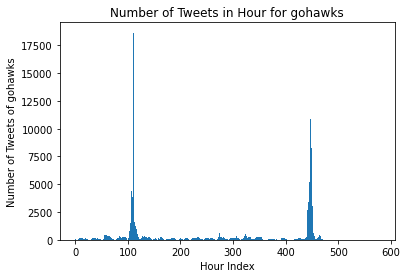

In [ ]:
plot_tws_in_hour(tweet_gohawks, "gohawks")

Lastest Citation Date:  2015-02-07 07:54:35
Earliest Citation Date:  2015-01-14 09:50:11


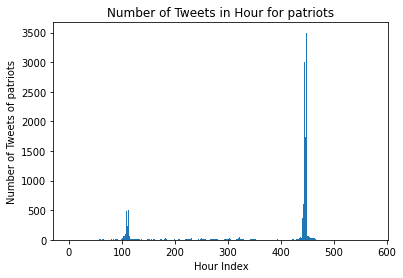

In [ ]:
plot_tws_in_hour(tweet_gopatriots, "patriots")

In [ ]:
#@markdown Time bounds during the game.
#@markdown - Lower bound: `time_lo_bound`.
time_lo_bound = time.mktime(datetime.datetime(2015, 2, 1, 23, 15, 0, 0, pst_tz).timetuple())
#@markdown - Lower bound: `time_up_bound`.
time_up_bound = time.mktime(datetime.datetime(2015, 2, 2, 3, 15, 0, 0, pst_tz).timetuple())

In [ ]:
#@markdown Helper functions
#@markdown - `clean(text)`: removes tags, urls, etc.
def clean(text):
  words = text.split()  
  for n,word in enumerate(words):
    if "@" in word or "t.co" in word or "#" in word:
      words[n] = ""          
  text = " ".join(filter(None,words))
  text = text.lower()
  text = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', text)
  text = text.replace(r'/', " ")
  text = re.sub(r'[^\w\s]', '', text)
  texter = re.sub(r"<br />", " ", text)
  texter = re.sub(r"&quot;", "\"",texter)
  texter = re.sub('&#39;', "\"", texter)
  texter = re.sub(' u '," you ", texter)
  texter = re.sub('`',"", texter)
  texter = re.sub(' +', ' ', texter)
  texter = re.sub(r"(!)\1+", r"!", texter)
  texter = re.sub(r"(\?)\1+", r"?", texter)
  texter = re.sub('&amp;', 'and', texter)
  texter = re.sub('\r', ' ',texter)  
  clean = re.compile('<.*?>')
  texter = re.sub(clean, '', texter)
  return texter

def get_wordnet_pos(tag):
  if tag[0] == 'J':
    return wordnet.ADJ
  elif tag[0] == 'V':
    return wordnet.VERB
  elif tag[0] == 'R':
    return wordnet.ADV
  else:
    return wordnet.NOUN
#@markdown - `lemmatize(tweet)`: might affect analyzing sentiment level.
def lemmatize(tweet):
  tokens = word_tokenize(tweet)
  words = [
    wnl.lemmatize(word, (get_wordnet_pos(tag))) \
    for word, tag in pos_tag(tokens) \
    if wnl.lemmatize(word, (get_wordnet_pos(tag))).isalpha()
  ]
  sentence = ' '.join(words)
  return sentence

#@markdown - `extract_features(tweets)`: extract `citation_date` and `tweet_text`.
def extract_features(tweets):
  citation_dates = []
  tweet_texts = []
  for tw in tweets:
    post_time = tw["citation_date"]
    if time_lo_bound <= post_time <= time_up_bound:
      text = tw['tweet']['text']
      if NER(text).doc._.language['language'] == 'en':
        citation_dates.append(post_time)
        tweet_texts.append(text)
  return citation_dates, tweet_texts

In [ ]:
#@markdown Player lists
#@markdown - Hawks Players: `h_players`
h_players = [
  "Russell Wilson", "Tarvaris Jackson", "B.J. Daniels", "Marshawn Lynch",
  "Robert Turbin", "Christine Michael","Will Tukuafu","Luke Wilson", 
  "Tony Moeaki", "Cooper Helfet","Doug Baldwin", "Jermaine Kearse", 
  "Ricardo Lockette", "Chris Matthews", "Kevin Norwood", "Bryan Walters",
  "Alvin Bailey", "Justin Britt", "Russell Okung", "Lemuel Jeanpierre", 
  "Keavon Milton", "J.R. Sweezy", "James Carpenter", "Max Unger", "Patrick Lewis",
  "Cliff Avril", "Michael Bennett", "Demarcus Dobbs", "David King", 
  "O'Brien Schofield","Kevin Williams", "Tony McDaniel", "Landon Cohen",
  "Bruce Irvin", "K.J. Wright", "Bobby Wagner", "Malcolm Smith", "Mike Morgan", 
  "Brock Coyle","Richard Sherman", "Byron Maxwell", "Jeremy Lane", 
  "DeShawn Shead", "Tharold Simon", "Marcus Burley","Earl Thomas", 
  "Kam Chancellor", "Steven Terrell", "Jeron Johnson","Steven Hauschka",
  "Jon Ryan", "Clint Gresham"
]
#@markdown - Patriots Players: `p_players`
p_players = [
  "Tom Brady", "Jimmy Garoppolo","Shane Vereen", "LeGarrette Blount", 
  "Brandon Bolden", "Jonas Gray", "James White","James Develin",
  "Rob Gronkowski", "Michael Hoomanawanui", "Tim Wright","Julian Edelman", 
  "Brandon LaFell", "Danny Amendola", "Josh Boyce", "Matthew Slater", 
  "Brian Tyms", "Nate Solder", "Sebastian Vollmer", "Jordan Devey", 
  "Cameron Fleming", "Dan Connolly", "Marcus Cannon", "Josh Fline", 
  "Bryan Stork", "Ryan Wendell","Chandler Jones", "Rob Ninkovich", 
  "Alan Branch", "Zach Moore", "Joe Vellano", "Vince Wilfork","Chris Jones", 
  "Sealver Siliga","Jonathan Casillas", "Jamie Collins", "Darius Fleming", 
  "Dont'a Hightower", "Chris White", "Akeem Ayers","Darrelle Revis", 
  "Malcolm Butler", "Brandon Browner", "Kyle Arrington", "Logan Ryan",
  "Patrick Chung", "Devin McCourty", "Nate Ebner", "Duron Harmon", 
  "Tavon Wilson","Stephen Gostkowski","Ryan Allen","Danny Aiken"
]
h_players = set([player.lower() for player in h_players])
p_players = set([player.lower() for player in p_players])
#@markdown - All Players: `players`
players = h_players.union(p_players)

In [ ]:
#############################
#  next cell takes a while  #
#############################

In [ ]:
gh_times, gh_texts = extract_features(tweet_gohawks)

In [ ]:
gp_times, gp_texts = extract_features(tweet_gopatriots)

In [ ]:
#@markdown Report the number of tweets during the game.
print("Number of tweets posted #gohawks: ", len(gh_times))
print("Number of tweets posted #gopatriots: ", len(gp_times))

Number of tweets posted #gohawks:  25875
Number of tweets posted #gopatriots:  6933


In [ ]:
#@markdown Clean gh text: `cleaned_gh_texts`.
cleaned_gh_texts = []
for text in gh_texts:
  cleaned = clean(text)
  cleaned_gh_texts.append(cleaned)

In [ ]:
#@markdown Clean gp text: `cleaned_gp_texts`.
cleaned_gp_texts = []
for text in gp_texts:
  cleaned = clean(text)
  cleaned_gp_texts.append(cleaned)

In [ ]:
#@markdown Get players mentioned in #gohawks tweets: `mentioned_players_gh`
#@markdown - Contains: player name, indice of tweets mentioning them.
mentioned_players_gh = defaultdict(list)
for i, text in enumerate(cleaned_gh_texts):
  doc_ner = NER(text)         # used to analyze entity
  for word in doc_ner.ents:
    if word.label_ == "PERSON" and word.text in players:
      mentioned_players_gh[word.text].append(i)

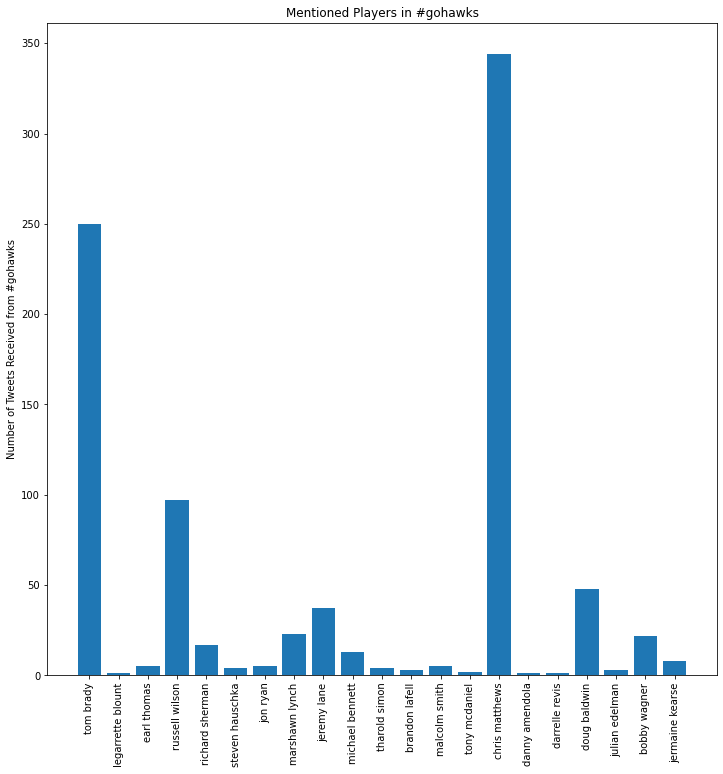

In [ ]:
#@markdown Mentioning counts for each player in #gohawks
mentioned_players_gh_keys = list(mentioned_players_gh.keys())
num_tws_received_gh = []
for p in mentioned_players_gh_keys:
  num_tws_received_gh.append(len(mentioned_players_gh[p]))
plt.figure(figsize=(12, 12))
ax = plt.axes()
plt.bar(np.arange(len(num_tws_received_gh)), num_tws_received_gh)
plt.xticks(rotation = 90)
ax.set_xticks(np.arange(len(num_tws_received_gh)))
ax.set_xticklabels(mentioned_players_gh_keys)
ax.set_ylabel("Number of Tweets Received from #gohawks")
plt.title("Mentioned Players in #gohawks")
plt.show()

In [ ]:
#@markdown Get players mentioned in #gopatirots tweets: `mentioned_players_gp`
#@markdown - Contains: player name, indice of tweets mentioning them.
mentioned_players_gp = defaultdict(list)
for i, text in enumerate(cleaned_gp_texts):
  doc_ner = NER(text)         # used to analyze entity
  for word in doc_ner.ents:
    if word.label_ == "PERSON" and word.text in players:
      mentioned_players_gp[word.text].append(i)

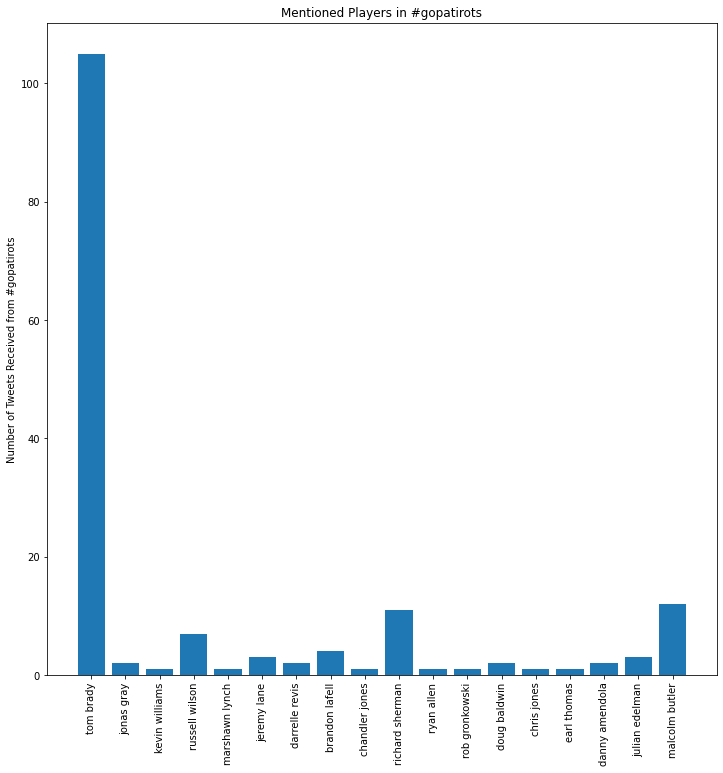

In [ ]:
#@markdown Mentioning counts for each player in #gopatriots
mentioned_players_gp_keys = list(mentioned_players_gp.keys())
num_tws_received_gp = []
for p in mentioned_players_gp_keys:
  num_tws_received_gp.append(len(mentioned_players_gp[p]))
plt.figure(figsize=(12, 12))
ax = plt.axes()
plt.bar(np.arange(len(num_tws_received_gp)), num_tws_received_gp)
plt.xticks(rotation = 90)
ax.set_xticks(np.arange(len(num_tws_received_gp)))
ax.set_xticklabels(mentioned_players_gp_keys)
ax.set_ylabel("Number of Tweets Received from #gopatirots")
plt.title("Mentioned Players in #gopatirots")
plt.show()

In [ ]:
#@markdown Top 5 mentioned players in #gohawks
mentioned_gh_df = pd.DataFrame()
mentioned_gh_df['player'] = mentioned_players_gh_keys
mentioned_gh_df['mentioned times'] = num_tws_received_gh
mentioned_gh_df.sort_values('mentioned times', ascending=False).head()

,player,mentioned times
14,chris matthews,344
0,tom brady,250
3,russell wilson,97
17,doug baldwin,48
8,jeremy lane,37


In [ ]:
#@markdown Top 5 mentioned players in #gopatriots.
mentioned_gp_df = pd.DataFrame()
mentioned_gp_df['player'] = mentioned_players_gp_keys
mentioned_gp_df['mentioned times'] = num_tws_received_gp
mentioned_gp_df.sort_values('mentioned times', ascending=False).head()

,player,mentioned times
0,tom brady,105
17,malcolm butler,12
9,richard sherman,11
3,russell wilson,7
7,brandon lafell,4


In [ ]:
#@markdown Top 5 mentioned players overall.
mentioned_df = pd.concat([
    mentioned_gh_df, 
    mentioned_gp_df
]).groupby(['player']).sum().reset_index()
mentioned_df.sort_values('mentioned times', ascending=False).head()

,player,mentioned times
26,tom brady,355
4,chris matthews,344
22,russell wilson,104
7,doug baldwin,50
9,jeremy lane,40


In [ ]:
top5_mentioned_players = set(mentioned_df.sort_values('mentioned times', ascending=False)['player'][:5])
top5_mentioned_players

{'chris matthews',
 'doug baldwin',
 'jeremy lane',
 'russell wilson',
 'tom brady'}

In [ ]:
# record big events from ESPN
start_time = 1422833046
big_events = {
    1422836015 - 60: 7,       # touchdown P 7: 0
    1422837198 - 60: 0,       # touchdown H 7: 7
    1422838767 - 6 * 60: 7,   # touchdown P 14: 7
    1422838767 - 60: 0,       # touchdown H 14: 14
    1422841327 - 60: -3,      # field goal H 14: 17
    1422841327 + 3 * 60: -3,  # interception H 14: 17
    1422842399 - 60: -10,     # touchdown H 14: 24
    1422844127 - 60: -3,      # touchdown P 21: 24
    1422845305 - 60: 4,       # touchdown P
    1422846605 - 5 * 60: 4,   # interception P
    1422846605 : 4            # game: P won
}

In [ ]:
min_gh_time = min(gh_times)
max_gh_time = max(gh_times)
datetime.datetime.fromtimestamp(min_gh_time)

datetime.datetime(2015, 2, 1, 23, 15)

In [ ]:
min_gp_time = min(gp_times)
max_gp_time = max(gp_times)
datetime.datetime.fromtimestamp(min_gp_time)

datetime.datetime(2015, 2, 1, 23, 15)

In [ ]:
def extract_player_influence(texts, times, player, mentioned_dict, min_time, time_window_size):
  twts_mentioning_player_is = mentioned_dict[player]
  sentiments_player = defaultdict(list)
  for i in twts_mentioning_player_is:
    current_time = times[i]
    text = texts[i]
    polarity = TextBlob(text).sentiment.polarity
    index = math.floor((current_time - min_time) / time_window_size)
    sentiments_player[index].append(polarity)
  
  avg_sentiments = defaultdict()
  for i in list(sentiments_player.keys()):
    avg_pol = np.mean(sentiments_player[i])
    avg_sentiments[i] = avg_pol

  xs_player = list(avg_sentiments.values())
  zero_sentiment_is = []
  for i, sent in enumerate(xs_player):
    if sent == 0:
      zero_sentiment_is.append(i)

  xs_filtered = [xs_player[i] for i in range(len(xs_player)) if i not in zero_sentiment_is]
  
  ys_player = defaultdict(list)
  for i in range(len(texts)):
    current_time = times[i]
    index = math.floor((current_time - min_time) / time_window_size)
    if index in set(avg_sentiments.keys()):
      text = texts[i]
      polarity = TextBlob(text).sentiment.polarity
      ys_player[index].append(polarity)
  
  ys_avg = defaultdict()
  for i in list(ys_player.keys()):
    ys_avg[i] = np.mean(ys_player[i])
  ys_filtered = [list(ys_avg.values())[i] for i in range(len(list(ys_avg.values()))) if i not in zero_sentiment_is]
  
  return xs_filtered, ys_filtered
  


In [ ]:
def plot_player_influence(texts, times, player, mentioned_dict, min_time, time_window_size, title):
  xs_filtered, ys_filtered = extract_player_influence(
      texts, 
      times,
      player,
      mentioned_dict,
      min_time,
      time_window_size
  )
  df = pd.DataFrame()
  df["x"] = xs_filtered
  df["y"] = ys_filtered
  sns.lmplot(x='x', y='y', data=df)
  plt.title(title)
  plt.show()

## Influence of top 5 players

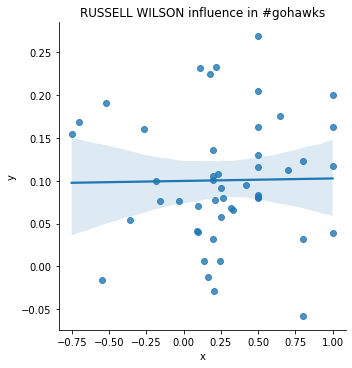

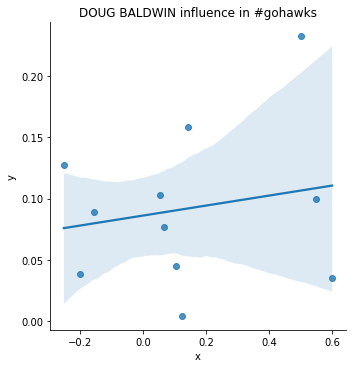

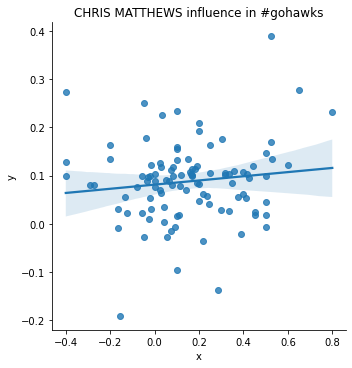

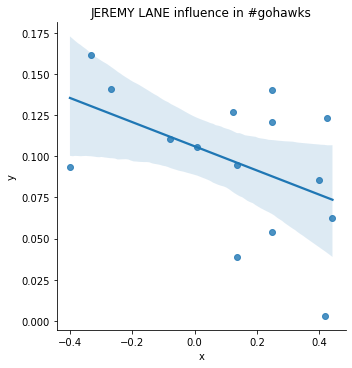

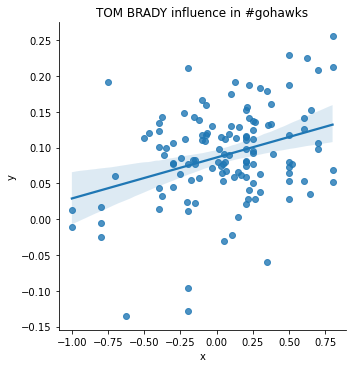

In [ ]:
for player in top5_mentioned_players:
  plot_player_influence(
      cleaned_gh_texts,
      gh_times, 
      player,
      mentioned_players_gh,
      min_gh_time,
      10,
      player.upper() + " influence in #gohawks" 
  )

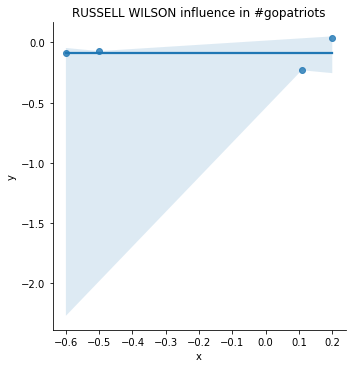

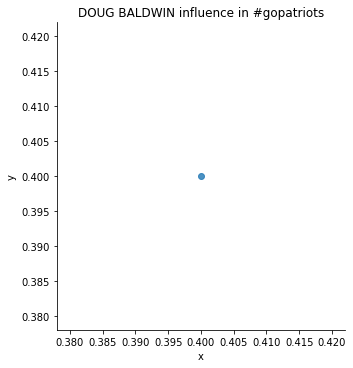

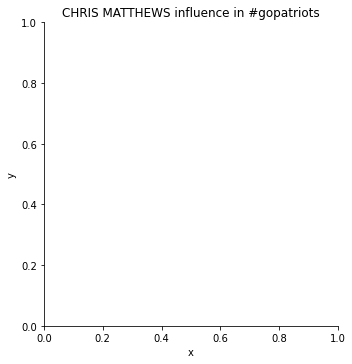

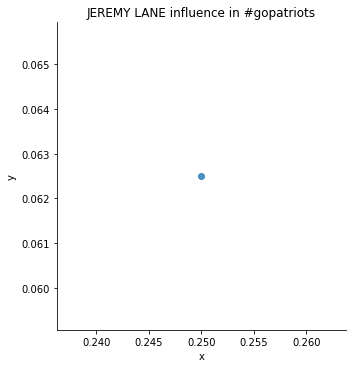

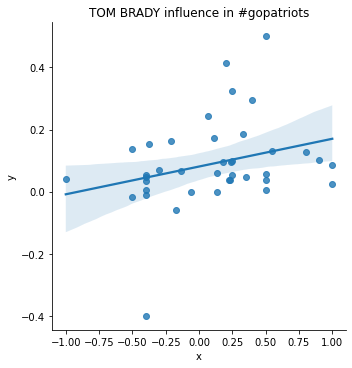

In [ ]:
for player in top5_mentioned_players:
  plot_player_influence(
      cleaned_gp_texts,
      gp_times, 
      player,
      mentioned_players_gp,
      min_gp_time,
      10,
      player.upper() + " influence in #gopatriots" 
  )

In [ ]:
big_event_times = list(big_events.keys())
len(big_event_times)

11

In [ ]:
big_event_time_ranges = []
for i in range(len(big_event_times)):
  if i < len(big_event_times) - 1:
    big_event_time_ranges.append((big_event_times[i], big_event_times[i+1]))
big_event_time_ranges.append((big_event_times[-1], max(max_gh_time, max_gp_time)))
big_event_time_ranges

[(1422835955, 1422837138),
 (1422837138, 1422838407),
 (1422838407, 1422838707),
 (1422838707, 1422841267),
 (1422841267, 1422841507),
 (1422841507, 1422842339),
 (1422842339, 1422844067),
 (1422844067, 1422845245),
 (1422845245, 1422846305),
 (1422846305, 1422846605),
 (1422846605, 1422846900)]

In [ ]:
def extract_player_pos_neg_counts_in_ranges(texts, times, player, mentioned_dict, min_time):
  
  big_events_times = list(big_events.keys())
  mentioning_player_is = mentioned_dict[player]
  pos_counts_in_ranges = [0] * len(big_event_times)  
  neg_counts_in_ranges = [0] * len(big_event_times)
  pos_sentiments_in_ranges = [0] * len(big_event_times)
  neg_sentiments_in_ranges = [0] * len(big_event_times)
  for i in mentioning_player_is:
    current_time = times[i]
    for index, range in enumerate(big_event_time_ranges):
      if range[0] <= current_time <= range[1]:
        text = texts[i]
        polarity = TextBlob(text).sentiment.polarity
        
        if polarity > 0:
          pos_counts_in_ranges[index] += 1
          pos_sentiments_in_ranges[index] += polarity
        elif polarity < 0:
          neg_counts_in_ranges[index] += 1
          neg_sentiments_in_ranges[index] += polarity
  avg_sentiments = []
  return pos_counts_in_ranges, neg_counts_in_ranges, pos_sentiments_in_ranges, neg_sentiments_in_ranges


In [ ]:
def get_xs_ys(texts, times, player, mentioned_dict, min_time):
  pos_counts, neg_counts, pos_sentiments, neg_sentiments = extract_player_pos_neg_counts_in_ranges(
    texts,
    times,
    player,
    mentioned_dict,
    min_time
  )
  df = pd.DataFrame()
  df["pos counts"] = pos_counts
  df["neg counts"] = neg_counts
  df["pos sentiments"] = pos_sentiments
  df["neg sentiments"] = neg_sentiments
  df["score"] = big_events.values()
  sns.heatmap(df.corr(), annot=True)
  plt.title(player.upper() + " : Correlation with game score difference")
  plt.show()

  xs = df.drop(["score"], axis=1)
  ys = df["score"]
  return xs, ys

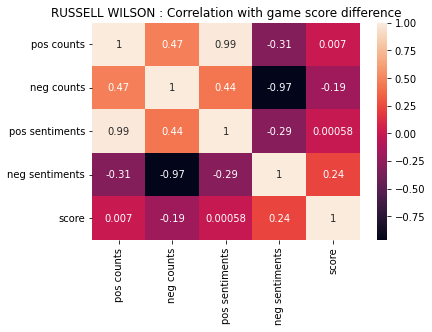

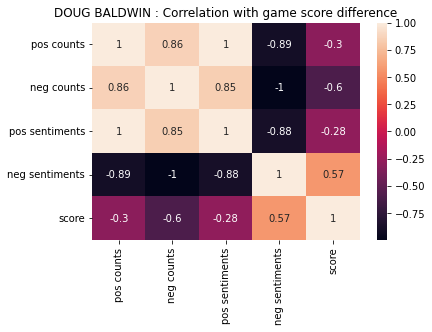

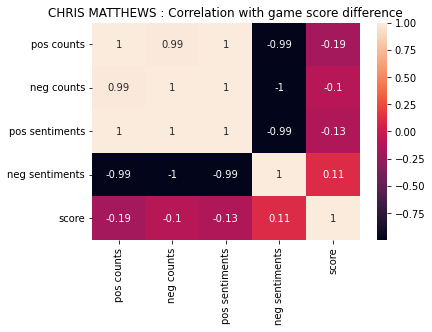

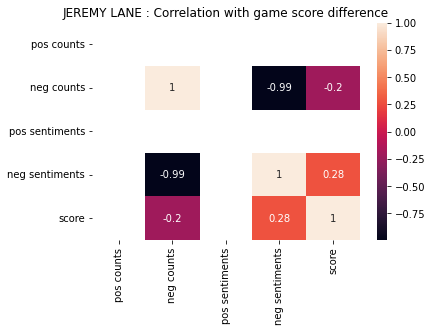

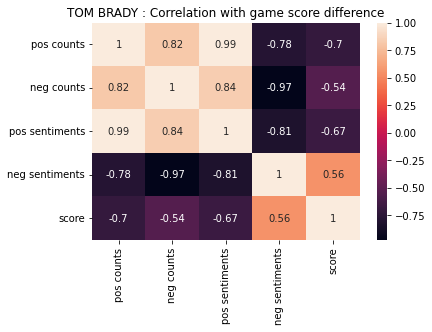

In [ ]:
players_xs = defaultdict()
players_ys = defaultdict()
for player in top5_mentioned_players:
  xs, ys = get_xs_ys(
      cleaned_gh_texts,
      gh_times,
      player,
      mentioned_players_gh,
      min_gh_time
  )
  players_xs[player] = xs
  players_ys[player] = ys

In [ ]:
def report_linear_regression(player, xs, ys):
  lr_pip_std = Pipeline([
    ('standardize', preprocessing.StandardScaler()),
    ('model', LinearRegression())
  ])
  cv = cross_validate(
      lr_pip_std, 
      xs, ys, 
      scoring='neg_root_mean_squared_error', 
      return_train_score=True, cv=10
  )
  return pd.DataFrame(cv).sort_values(by=['test_score'], ascending=False).reset_index(drop=True)

In [ ]:
def report_ridge(player, xs, ys):
  poly_pip = Pipeline([
    ('poly_transform', PolynomialFeatures()),
    ('standardize', StandardScaler()),
    ('model', Ridge(alpha=0.001, random_state=42, max_iter=10000))
  ])
  param_grid_poly = {
      'poly_transform__degree': np.arange(1,11,1)
  }
  poly_cv  = GridSearchCV(
    poly_pip, 
    param_grid=param_grid_poly, 
    cv=10, 
    n_jobs=-1, 
    verbose=1, 
    scoring='neg_root_mean_squared_error', 
    return_train_score=True
  ).fit(x, ys)
  poly_res = pd.DataFrame(poly_cv.cv_results_)[['mean_test_score', 'mean_train_score', 'param_poly_transform__degree']]
  poly_res = poly_res.sort_values(by=['mean_test_score'], ascending=False).reset_index(drop=True)
  return poly_res


In [ ]:
def report_lasso(player, xs, ys):
  poly_pip = Pipeline([
      ('poly_transform', PolynomialFeatures()),
      ('standardize', StandardScaler()),
      ('model', Lasso(alpha=0.01, random_state=42, max_iter=2000))
  ])
  param_grid_poly = {
      'poly_transform__degree': np.arange(5,11,1)
  }
  poly_cv  = GridSearchCV(
    poly_pip, 
    param_grid=param_grid_poly, 
    cv=10, 
    n_jobs=-1, 
    verbose=1, 
    scoring='neg_root_mean_squared_error', 
    return_train_score=True
  ).fit(xs, ys)
  poly_res = pd.DataFrame(poly_cv.cv_results_)[['mean_test_score', 'mean_train_score', 'param_poly_transform__degree']]
  poly_res = poly_res.sort_values(by=['mean_test_score'], ascending=False).reset_index(drop=True)
  return poly_res


# Top mentioned players Linear Regression reports 

In [ ]:
for player in top5_mentioned_players:
  xs = players_xs[player]
  ys = players_ys[player]
  print(player.upper() + " Linear Regression")
  df_lr = report_linear_regression(player, xs, ys)
  print(df_lr.head())

RUSSELL WILSON Linear Regression
   fit_time  score_time  test_score  train_score
0  0.004483    0.001956   -3.760876    -4.841501
1  0.004268    0.001851   -4.104803    -4.832058
2  0.004944    0.002641   -4.512260    -4.791824
3  0.004312    0.001779   -6.720063    -4.701494
4  0.004344    0.001765   -7.378392    -4.482794
DOUG BALDWIN Linear Regression
   fit_time  score_time  test_score  train_score
0  0.003969    0.001738   -2.000000    -3.405877
1  0.003964    0.001712   -2.000000    -3.405877
2  0.004018    0.001725   -2.000000    -3.405877
3  0.004050    0.001734   -2.500000    -3.376389
4  0.005413    0.002019   -3.866391    -3.177300
CHRIS MATTHEWS Linear Regression
   fit_time  score_time  test_score  train_score
0  0.004062    0.001710   -0.336866    -2.663301
1  0.005712    0.002029   -0.637206    -2.659985
2  0.004138    0.001721   -2.486149    -2.637850
3  0.004949    0.001845   -2.967170    -2.513994
4  0.004494    0.001730   -3.116229    -2.504077
JEREMY LANE Linear Re

# Top mentioned players Ridge reports 

In [ ]:
for player in top5_mentioned_players:
  xs = players_xs[player]
  ys = players_ys[player]
  print(player.upper() + " Ridge")
  df_lr = report_ridge(player, xs, ys)
  print(df_lr.head())

RUSSELL WILSON Ridge
Fitting 10 folds for each of 10 candidates, totalling 100 fits
   mean_test_score  mean_train_score param_poly_transform__degree
0        -4.218988         -2.863532                            1
1       -11.872101         -0.866559                            2
2       -25.350811         -0.772904                            5
3       -31.751527         -0.793406                            3
4       -33.065344         -0.778602                            4
DOUG BALDWIN Ridge
Fitting 10 folds for each of 10 candidates, totalling 100 fits
   mean_test_score  mean_train_score param_poly_transform__degree
0        -4.218988         -2.863532                            1
1       -11.872101         -0.866559                            2
2       -25.350811         -0.772904                            5
3       -31.751527         -0.793406                            3
4       -33.065344         -0.778602                            4
CHRIS MATTHEWS Ridge
Fitting 10 folds for 

# Top mentioned players Lasso reports 

In [ ]:
for player in top5_mentioned_players:
  xs = players_xs[player]
  ys = players_ys[player]
  print(player.upper() + " Lasso")
  df_lr = report_lasso(player, xs, ys)
  print(df_lr.head())

RUSSELL WILSON Lasso
Fitting 10 folds for each of 6 candidates, totalling 60 fits


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.557e+01, tolerance: 2.685e-02
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


   mean_test_score  mean_train_score param_poly_transform__degree
0      -251.183960         -3.804564                            5
1      -576.396709         -3.803392                            6
2     -1242.863880         -3.803919                            7
3     -2610.463045         -3.804755                            8
4     -4905.971952         -3.805319                            9
DOUG BALDWIN Lasso
Fitting 10 folds for each of 6 candidates, totalling 60 fits
   mean_test_score  mean_train_score param_poly_transform__degree
0       -17.010939         -3.271431                            5
1       -17.010939         -3.271431                            6
2       -17.010939         -3.271431                            7
3       -17.010939         -3.271431                            8
4       -17.010939         -3.271431                            9
CHRIS MATTHEWS Lasso
Fitting 10 folds for each of 6 candidates, totalling 60 fits


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.022e-01, tolerance: 2.685e-02
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


   mean_test_score  mean_train_score param_poly_transform__degree
0     -1755.052006         -2.382248                            5
1     -3568.388975         -2.382223                            6
2     -6957.757831         -2.382190                            7
3    -31799.674003         -2.382131                            8
4    -55233.933949         -2.382123                            9
JEREMY LANE Lasso
Fitting 10 folds for each of 6 candidates, totalling 60 fits


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.433e-01, tolerance: 2.685e-02
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


   mean_test_score  mean_train_score param_poly_transform__degree
0        -6.050291         -3.178121                           10
1        -6.050314         -3.178227                            6
2        -6.050314         -3.178182                            7
3        -6.050314         -3.178302                            5
4        -6.050314         -3.178154                            8
TOM BRADY Lasso
Fitting 10 folds for each of 6 candidates, totalling 60 fits
   mean_test_score  mean_train_score param_poly_transform__degree
0       -23.076516         -1.394640                            5
1       -23.100587         -1.394142                            6
2       -23.110426         -1.393988                            7
3       -23.115393         -1.393931                            8
4       -23.118265         -1.393905                            9


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.857e+00, tolerance: 2.685e-02
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
